<a href="https://colab.research.google.com/github/jonasbarth/bdc-homework-2/blob/main/HW2_2023.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Amazon Fine Food Reviews - Building a Co-review graph

In this lab, our general goal is to conduct some exploratory analysis of a medium - large dataset, namely, Amazon Fine Food Reviews, available from a [Kaggle Competition](https://www.kaggle.com/datasets/snap/amazon-fine-food-reviews).

Our general goals are the following:

- Retrieve the dataset and upload it onto Colab;
- Build the associated Co-review graph.

## Retrieving the dataset
To retrieve this dataset, we need to be registered Kaggle users. Assuming this is the case, we basically have two options:

1. Download the dataset locally. This can be useful if you want to keep a copy of the data to work with directly on your machine. In this case, you will have to upload the data on Colab in order to work with it. There are several ways to do this, described [here](https://colab.research.google.com/notebooks/io.ipynb). Note that our compressed dataset is about 300MB's and proceeding this way may take some time, depending on your connection.
2. Transferring the data directly from Kaggle to Google. In my experience, this was extremely fast and it is the method I am going to use.

A nice review of all available methods, including the one I am using, can be found [here](https://towardsdatascience.com/7-ways-to-load-external-data-into-google-colab-7ba73e7d5fc7).

### Transferring dataset from Google to Colab
Go to your profile on Kaggle, then ```Account --> Create New API Token``` (you do not have to do every time you run your notebook). The result will be a file called ```kaggle.json```, which you save on your machine. Next, we upload this file to Google Colab as follows:

In [1]:
from google.colab import files

uploaded = files.upload()

Saving kaggle.json to kaggle.json


We next specify the above directory as the one to upload the Kaggle dataset to:

In [2]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

Next, we need to upload the dataset, issuing the necessary shell command. To do this, we can let Kaggle generate the right command for us. This is done from the Kaggle competion's Web page, in the top-right menu, clicking on the dots and then selecting ```Copy API Command``` as shown in the picture below:

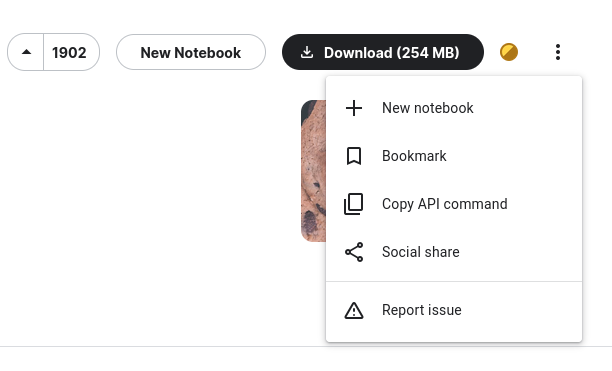

The copy-pasted command is the one shown below:

In [3]:
!kaggle datasets download -d snap/amazon-fine-food-reviews

 97% 234M/242M [00:01<00:00, 155MB/s]
100% 242M/242M [00:01<00:00, 161MB/s]


In [4]:
!chmod 600 /content/kaggle.json

We next check that everything is there:

In [ ]:
!ls

amazon-fine-food-reviews.zip  kaggle.json  sample_data


We now extract the files from the zipper archive. To this purpose, we use Python zipfile utility package:

In [5]:
from zipfile import ZipFile
from pathlib import Path

In [6]:
# Create a ZipFile Object and load sample.zip in it
with ZipFile('amazon-fine-food-reviews.zip', 'r') as zipObj:
    Path("./data").mkdir(exist_ok=True, parents=True)
   # Extract all the contents of zip file in current directory
    zipObj.extractall("./data")

Let's check what files are there (we are looking for ```Reviews.csv```)

In [7]:
!ls data

database.sqlite  hashes.txt  Reviews.csv


There it is. Let us just perform a check that the file looks like it is supposed to be, by having a glance at the first 10 lines:

In [8]:
!head -10 data/Reviews.csv

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,"Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as ""Jumbo""."
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all","This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally co

Keeping roughly $10\%$ of the users for testing purposes. We will see why doing this is reasonable further in the course. For now, try to understand how ```sample_users``` works and why it does the job.

#### Load the Reviews file.
As a first step, we load the `Reviews.csv` file.

In [9]:
import pandas as pd
raw_pd = pd.read_csv("data/Reviews.csv", index_col=0)

In [33]:
raw_pd

,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
Id,,,,,,,,,
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...
...,...,...,...,...,...,...,...,...,...
568450,B001EO7N10,A28KG5XORO54AY,Lettie D. Carter,0,0,5,1299628800,Will not do without,Great for sesame chicken..this is a good if no...
568451,B003S1WTCU,A3I8AFVPEE8KI5,R. Sawyer,0,0,2,1331251200,disappointed,I'm disappointed with the flavor. The chocolat...
568452,B004I613EE,A121AA1GQV751Z,"pksd ""pk_007""",2,2,5,1329782400,Perfect for our maltipoo,"These stars are small, so you can give 10-15 o..."


We write the **product ID** and **user ID** of the sampled rows to the provided `fout` file, with columns separated by comma `,`. We only save these two columns because for the co-review graph, those are the columns we need.

In [52]:
# Given a Pandas frame raw_pd, save lines corresponding to approximately 10% of the users to file fout
# Note that all lines corresponding to sampled users are saved to fout

def sample_users(raw_pd, rate, buckets, fout):
    for index, row in raw_pd.iterrows():
        if (hash(row["UserId"])%buckets < rate):
            row_str = ",".join(map(str, [row["ProductId"], row["UserId"]]))
            fout.write(row_str)
            fout.write("\n")
            # Save this line to fout
            # You have to complete this part of the function's body


sampled_file = "data/Reviews_sampled.csv"
rate = 10 # 10% of users
buckets = 100

fout = open(sampled_file, "w")
sample_users(raw_pd, rate, buckets, fout)
fout.close()

In [51]:
!rm data/Reviews_sampled.csv

In [30]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 316.9/316.9 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.0-py2.py3-none-any.whl size=317425344 sha256=c02653de1143f499aa824b956dd27301b738c1620508e47302d9a6b1c9b89b5a
  Stored in directory: /root/.cache/pip/wheels/41/4e/10/c2cf2467f71c678cfc8a6b9ac9241e5e44a01940da8fbb17fc
Successfully built pyspark


In [53]:
from pyspark import SparkContext, SparkConf
sc.stop()
sc = SparkContext(appName="co-review-graph").getOrCreate()
file_in = "data/Reviews_sampled.csv"
f = sc.textFile(file_in)

In [88]:
# first I want to map each product to all the users that have reviewed that product
common_reviewers = f.map(lambda line: line.split(",")).map(lambda user_product: (user_product[0], [user_product[1]])).reduceByKey(lambda user1, user2: user1 + user2)

# then I want to create pairs of users that have reviewed the same product
co_reviewers = common_reviewers.map(lambda product_users: product_users[1]).flatMap(lambda users: [(user1, user2) for user1 in users for user2 in users])

# Map each user pair to a key-value pair, where key is (user1, user2) and value is 1
user_pairs = co_reviewers.map(lambda pair: ((pair[0], pair[1]), 1))

# Use reduceByKey to count the occurrences of each unique key
user_pair_counts = user_pairs.reduceByKey(lambda count1, count2: count1 + count2)

# Map the result to the desired output format
user_counts_format = user_pair_counts.map(lambda x: (x[0][0], [(x[0][1], x[1])]))

# Combine lists for the same user
user_counts_combined = user_counts_format.reduceByKey(lambda list1, list2: list1 + list2)

user_counts_sorted = user_counts_combined.mapValues(lambda user_counts: sorted(user_counts, key=lambda x: x[1], reverse=True))

# Collect the results or perform further actions
result = user_counts_sorted.collect()
result

[('A1D87F6ZCVE5NK', [('A1D87F6ZCVE5NK', 1)]),
 ('A2MUGFV2TDQ47K',
  [('A2MUGFV2TDQ47K', 201),
   ('ADS5APY1NKTL4', 30),
   ('AY1EF0GOH80EK', 18),
   ('AG7EF0SVBQOUX', 18),
   ('A1DW1FK1H3F2TM', 15),
   ('A37D5847LN3WQ', 15),
   ('A2MMTWKCJET6S', 14),
   ('A56JFSLUCHI4J', 14),
   ('A2BFFXK7TEINBE', 14),
   ('A22LENLDTGQIU7', 14),
   ('AWLK6NSSV0YNA', 14),
   ('A2EMS62FCYODRS', 14),
   ('A2OLJKXJBAYBTY', 14),
   ('A3ARZW7S96SESC', 14),
   ('A216YA3CYXIOGI', 14),
   ('A2PYL0PSX5MQYQ', 14),
   ('A1I29JSIGJNWKH', 14),
   ('A926YP1BSD72Y', 14),
   ('A17UR3NRLARXCH', 14),
   ('AJQD2WWJYOYFQ', 14),
   ('A3I5AT1101AS3A', 14),
   ('AX7K82LNPVATT', 14),
   ('A2933AO5D7O1T6', 14),
   ('ATLO3YXU2BC16', 12),
   ('AEL6CQNQXONBX', 11),
   ('A1ZU55TM45Y2R8', 11),
   ('A1X3ESYZ79H59E', 10),
   ('A4VMQ6ZTSXSSL', 10),
   ('A11OTLEDSW8ZXD', 9),
   ('A1EVV74UQYVKRY', 9),
   ('A3DOPYDOS49I3T', 8),
   ('A2BZ16RKE13PKV', 6),
   ('A2SNRRXE9M9ZDY', 6),
   ('A2SZLNSI5KOQJT', 6),
   ('A2OR4QUQSUMOW7', 6),
   ('A3P